# Librerías
___
### Básicas
- **`pandas`**: Biblioteca para manipulación y análisis de datos, especialmente útil para trabajar con datos estructurados como tablas (DataFrames).
- **`numpy`**: Herramienta fundamental para cálculos matemáticos, trabajando con arrays y álgebra lineal.
- **`matplotlib.pyplot`**: Biblioteca para crear gráficos y visualizaciones de datos básicos.
- **`seaborn`**: Extensión de Matplotlib para crear gráficos más atractivos y estadísticamente informativos.


### Selección de Modelos y Preprocesamiento
- **`KFold`**: Método de validación cruzada que divide los datos en pliegues (folds) para evaluar la robustez del modelo.
- **`StandardScaler`**: Escala las características para que tengan una media de 0 y una desviación estándar de 1, optimizando el rendimiento de los modelos.


### Construcción de Modelos con TensorFlow/Keras
- **`l2`**: Regularizador L2 que penaliza los pesos del modelo, ayudando a evitar el sobreajuste.
- **`Sequential`**: Clase de Keras para construir modelos neuronales capa a capa, de forma secuencial.
- **`Dense`**: Capa densamente conectada para redes neuronales.
- **`Dropout`**: Técnica de regularización que apaga nodos aleatoriamente durante el entrenamiento.
- **`BatchNormalization`**: Normaliza las entradas de cada capa, mejorando la estabilidad del modelo.


### Callbacks de Keras
- **`EarlyStopping`**: Callback que detiene el entrenamiento si no hay mejoras en las métricas durante varias épocas consecutivas.
- **`ReduceLROnPlateau`**: Reduce dinámicamente la tasa de aprendizaje cuando el modelo deja de mejorar.


### Métricas y Optimizadores
- **`r2_score`**: Métrica que mide qué tan bien las predicciones se ajustan a los valores reales (coeficiente de determinación R²).
- **`Adam`**: Optimizador avanzado basado en gradientes adaptativos, eficiente para redes profundas.


### Almacenamiento y Carga de Modelos
- **`joblib`**: Herramienta para guardar objetos de Python, como modelos entrenados o escaladores, para reutilizarlos posteriormente.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
import joblib

import warnings

### Gestión de Advertencias
- **`warnings`**: Módulo para controlar las advertencias en Python.
- **`warnings.filterwarnings()`**: Se utiliza para ignorar advertencias específicas. En este caso:
  - **`category=UserWarning`**: Ignora las advertencias de usuario.
  - **`module="keras"`**: Ignora específicamente las advertencias relacionadas con Keras.

In [2]:
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

### Cargar los datos de generación y meteorológicos
- **`pd.read_csv()`**: Función de `Pandas` para cargar los datos desde archivos CSV.
  - **`plant_1_generation`**: Datos relacionados con la generación de energía de los paneles solares.
  - **`plant_1_weather`**: Datos meteorológicos capturados por sensores.


### Copiar los datos de generación para mantener el DataFrame original
- **`copy()`**: Realiza una copia del DataFrame original para evitar modificar los datos originales.


### Asignar nombres personalizados a los paneles solares
- **`unique()`**: Obtiene los valores únicos de la columna `SOURCE_KEY`.
- **`enumerate()`**: Genera índices y valores para asignar nombres personalizados como `Solar_Panel_1`, `Solar_Panel_2`, etc.
- **`map()`**: Reemplaza los valores de la columna `SOURCE_KEY` según un diccionario generado.


### Convertir las columnas de fecha y hora al formato datetime
- **`pd.to_datetime()`**: Convierte las columnas `DATE_TIME` a formato datetime, para facilitar operaciones basadas en fechas.


### Unir los datos meteorológicos con los de generación
- **`pd.merge()`**: Combina los datos de generación y meteorológicos mediante un "join" en la columna `DATE_TIME`.
  - **`how='left'`**: Incluye todos los datos de `df_SP1` y añade las columnas de `plant_1_weather` cuando coincidan las fechas.


### Eliminar y renombrar columnas para mayor claridad
- **`drop()`**: Elimina columnas innecesarias como `PLANT_ID_y` y `SOURCE_KEY_y`.
- **`rename()`**: Renombra columnas para mejorar la legibilidad, como cambiar `SOURCE_KEY_x` a `SOURCE_KEY`.

In [3]:
# Cargar los datos de generación y meteorológicos
plant_1_generation = pd.read_csv('Plant_1_Generation_Data.csv')
plant_1_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

# Copiar los datos de generación para mantener df_GD1 limpio
df_SP1 = plant_1_generation.copy()

# Aplicar el mapeo a los nombres de los paneles solares
unique_source_keys_list = df_SP1['SOURCE_KEY'].unique()
source_key_mapping = {key: f"Solar_Panel_{i+1}" for i, key in enumerate(unique_source_keys_list)}
df_SP1['SOURCE_KEY'] = df_SP1['SOURCE_KEY'].map(source_key_mapping)

# Convertir la columna 'DATE_TIME' a formato de fecha y hora
df_SP1['DATE_TIME'] = pd.to_datetime(df_SP1['DATE_TIME'], format='%d-%m-%Y %H:%M')
plant_1_weather['DATE_TIME'] = pd.to_datetime(plant_1_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Unir los datos meteorológicos al dataframe de generación en función de la fecha y hora
df_SP1_with_weather = pd.merge(df_SP1, plant_1_weather, on='DATE_TIME', how='left')

# Eliminar las columnas PLANT_ID_y y SOURCE_KEY_y y renombrar las columnas PLANT_ID_x y SOURCE_KEY_x
df_SP1_with_weather = df_SP1_with_weather.drop(columns=['PLANT_ID_y', 'SOURCE_KEY_y','PLANT_ID_x'])

# Renombrar las columnas para eliminar el sufijo '_x'
df_SP1_with_weather = df_SP1_with_weather.rename(columns={'SOURCE_KEY_x': 'SOURCE_KEY'})

### Mostrar cuántos valores nulos hay por columna
- **`isnull()`**: Identifica valores nulos en el DataFrame.
- **`sum()`**: Suma el número de valores nulos por columna.


### Rellenar valores nulos con la media
- **`select_dtypes()`**: Selecciona columnas numéricas para aplicar imputación.
- **`fillna()`**: Rellena valores nulos en las columnas numéricas con la media de cada una.
- **`mean()`**: Calcula la media de los valores no nulos en cada columna.

In [4]:
# Mostrar cuántos valores nulos hay por columna
print("Valores nulos en cada columna (planta 2):\n", df_SP1_with_weather.isnull().sum())

# Rellenar los valores nulos en solo las columnas numéricas con la media
numerical_cols = df_SP1_with_weather.select_dtypes(include=['float64', 'int64']).columns #EstO para quitar los floats
df_SP1_with_weather[numerical_cols] = df_SP1_with_weather[numerical_cols].fillna(df_SP1_with_weather[numerical_cols].mean())

Valores nulos en cada columna (planta 2):
 DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    4
MODULE_TEMPERATURE     4
IRRADIATION            4
dtype: int64


In [5]:
print(df_SP1_with_weather.isnull().sum())

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


___

In [6]:
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

### Definir características y objetivo
- **`variables`**: Lista de columnas seleccionadas como variables independientes para entrenar el modelo.
- **`X`**: Matriz de variables independientes extraída del DataFrame.
- **`Y`**: Vector de la variable objetivo, que corresponde a `DC_POWER`.

In [7]:
# Define features and target
variables = ['DAILY_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
X = df_SP1_with_weather[variables].values
Y = df_SP1_with_weather['DC_POWER'].values


---

### Visualización de valores atípicos con boxplots
- **Boxplots (gráficos de caja)**:
  - **`plt.figure()`**: Configura el tamaño general de la figura (15x10).
  - **`plt.subplot()`**: Organiza los gráficos en 2 filas y 3 columnas.
  - **`sns.boxplot()`**: Crea gráficos de caja para cada variable, mostrando su distribución y los valores atípicos.
  - **`plt.title()`**: Asigna un título a cada gráfico indicando la variable analizada.
  - **`plt.ylabel()`**: Etiqueta el eje Y con el nombre de la variable.
  - **`plt.tight_layout()`**: Ajusta los espacios entre gráficos para evitar superposiciones.
  - **`plt.show()`**: Muestra todos los gráficos generados.

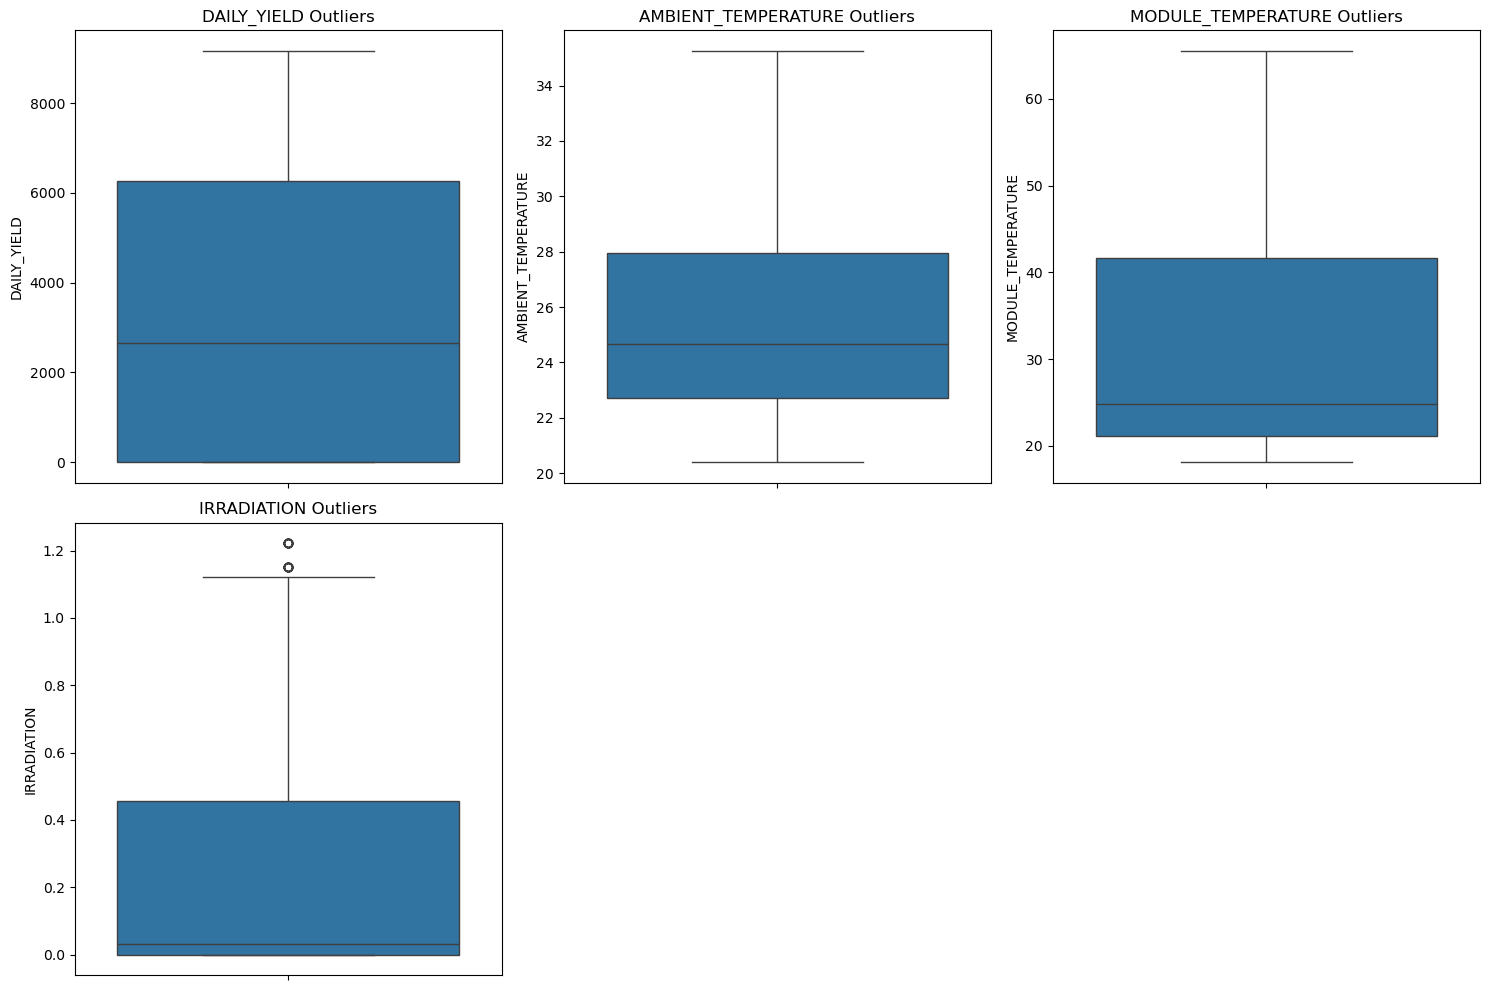

In [8]:
# Create boxplots to visualize outliers
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)  # Arrange in 2 rows and 3 columns
    sns.boxplot(data=df_SP1_with_weather, y=var)
    plt.title(f'{var} Outliers')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

### Filtrado de valores atípicos (Outliers)
- **Rango intercuartil (IQR)**:
  - **`quantile(0.25)`**: Calcula el primer cuartil (Q1), correspondiente al 25% de los datos más bajos.
  - **`quantile(0.75)`**: Calcula el tercer cuartil (Q3), correspondiente al 75% de los datos más altos.
  - **IQR**: Rango intercuartil, calculado como `IQR = Q3 - Q1`.
  - **Límites**:
    - **Límite inferior**: `Q1 - 1.5 * IQR`.
    - **Límite superior**: `Q3 + 1.5 * IQR`.
  - **Filtrado de valores atípicos**: Solo se mantienen los datos que están dentro de los límites definidos.


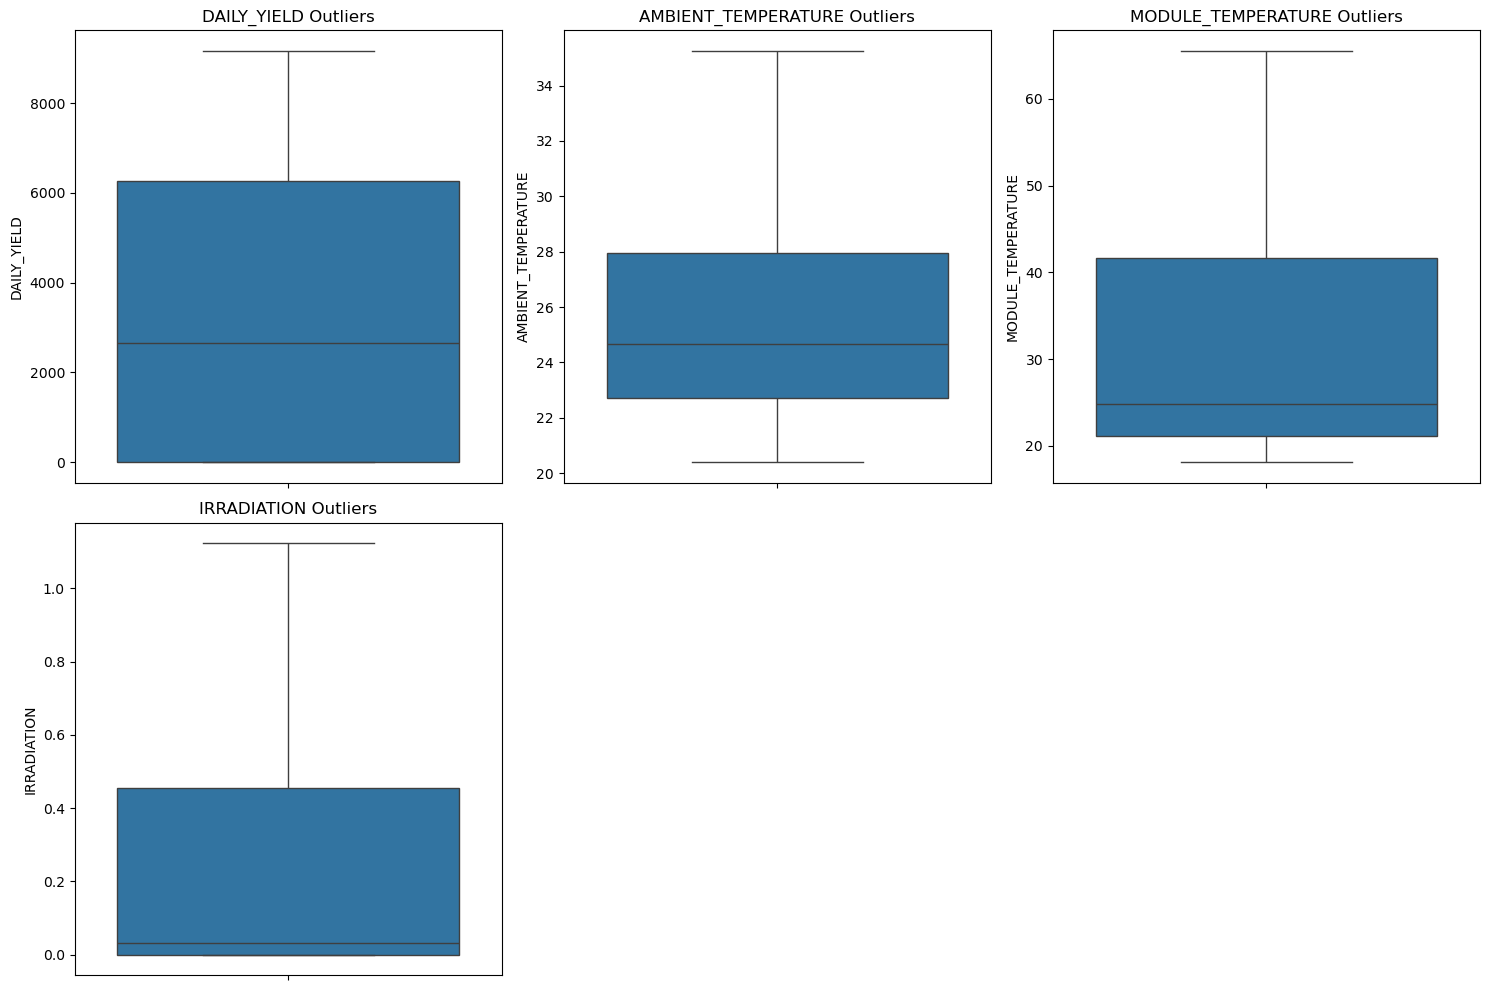

In [9]:
for var in variables:
    Q1 = df_SP1_with_weather[var].quantile(0.25)
    Q3 = df_SP1_with_weather[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_SP1_with_weather = df_SP1_with_weather[(df_SP1_with_weather[var] >= lower_bound) & (df_SP1_with_weather[var] <= upper_bound)]
    
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)  # Arrange in 2 rows and 3 columns
    sns.boxplot(data=df_SP1_with_weather, y=var)
    plt.title(f'{var} Outliers')
    plt.ylabel(var)
plt.tight_layout()
plt.show()


# Modelo
---

### Configuración de validación cruzada K-Fold
- **`KFold`**: Divide los datos en 10 subconjuntos (`n_splits=10`) para realizar validación cruzada.
  - **`shuffle=True`**: Mezcla los datos antes de dividirlos.
  - **`random_state=42`**: Semilla para asegurar que las divisiones sean reproducibles.
- Listas de métricas:
  - **`mse_scores`**: Almacena el error cuadrático medio (MSE) para cada pliegue.
  - **`mae_scores`**: Almacena el error absoluto medio (MAE) para cada pliegue.
  - **`r2_scores`**: Almacena el coeficiente de determinación (R²) para cada pliegue.

---

### División en entrenamiento y prueba
- **`kf.split()`**: Genera índices para dividir los datos en entrenamiento y prueba.
  - **`X_train`**, **`X_test`**: Conjuntos de datos de entrada para entrenamiento y prueba.
  - **`Y_train`**, **`Y_test`**: Conjuntos de datos de salida (objetivo) para entrenamiento y prueba.

---

### Escalado de datos
- **`StandardScaler`**: Normaliza las características para que tengan una media de 0 y desviación estándar de 1.
  - **`fit_transform`**: Ajusta el escalador a los datos de entrenamiento y los transforma.
  - **`transform`**: Aplica el escalador ajustado a los datos de prueba.
- **`joblib.dump()`**: Guarda el escalador en un archivo (`scaler_ker1.pkl`) para uso futuro.

---

### Creación del modelo
- **`Sequential`**: Clase para construir redes neuronales capa a capa.
- **Capas densas (`Dense`)**:
  - Capa oculta con 128, 64 y 32 neuronas, activación `relu` y regularización L2.
  - Capa de salida con una sola neurona para predecir un valor continuo.
- **`BatchNormalization`**: Normaliza las salidas de cada capa para estabilizar y acelerar el entrenamiento.
- **`Dropout`**: Desactiva un porcentaje de las neuronas (20%) en cada iteración para reducir el sobreajuste.
- **Compilación del modelo**:
  - **`Adam`**: Optimizador adaptativo con tasa de aprendizaje 0.001.
  - **`loss='mse'`**: Función de pérdida para minimizar el error cuadrático medio.
  - **`metrics=['mae']`**: Métrica adicional para evaluar el error absoluto medio.

---

### Callbacks
- **`EarlyStopping`**: Detiene el entrenamiento si no hay mejora en la pérdida de validación (`val_loss`) después de 5 épocas consecutivas.
- **`ReduceLROnPlateau`**: Reduce la tasa de aprendizaje en un factor de 0.5 si `val_loss` no mejora durante 3 épocas.

---

### Entrenamiento del modelo
- **`model.fit()`**:
  - **`epochs=100`**: Máximo de 100 épocas.
  - **`batch_size=32`**: Tamaño del lote para cada iteración.
  - **`validation_data`**: Datos de prueba utilizados para validar el modelo durante el entrenamiento.
  - **`callbacks`**: Incluye los callbacks configurados anteriormente (`early_stop` y `lr_scheduler`).

---

### Evaluación del modelo
- **`model.evaluate()`**:
  - Calcula las métricas de pérdida (`mse`) y error absoluto medio (`mae`) en el conjunto de prueba.
  - Los resultados se almacenan en las listas `mse_scores` y `mae_scores`.

---

### Predicciones y cálculo de R²
- **`model.predict()`**: Genera predicciones para los datos de prueba.
- **`r2_score()`**: Calcula el coeficiente de determinación (R²), que mide la calidad del ajuste del modelo.
- Los valores de R² se almacenan en la lista `r2_scores`.

---

### Reporte de resultados
- **`print()`**:
  - **`MSE per fold`**: Imprime el error cuadrático medio de cada pliegue.
  - **`MAE per fold`**: Imprime el error absoluto medio de cada pliegue.
  - **`R² per fold`**: Imprime el coeficiente de determinación para cada pliegue.
  - **Promedios**:
    - Calcula el promedio de MSE, MAE y R² para evaluar el desempeño general del modelo.


In [10]:
# KFold Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    # Train-Test split
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    joblib.dump(scaler, 'scaler_ker1.pkl')
    
    # Create model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='relu'))  # Output layer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    # Train model
    history = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0,
                        validation_data=(X_test, Y_test),
                        callbacks=[early_stop, lr_scheduler]) 
    
    # Evaluate
    mse, mae = model.evaluate(X_test, Y_test, verbose=0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    Y_test_pred = model.predict(X_test, verbose=0)
    r2 = r2_score(Y_test, Y_test_pred)
    r2_scores.append(r2)
    
    # Predicciones y cálculo de R²
    Y_pred = model.predict(X_test, verbose=0)
    r2 = r2_score(Y_test, Y_pred)
    r2_scores.append(r2)

# Report Results
print("MSE per fold:", mse_scores)
print("Average MSE:", np.mean(mse_scores))
print("MAE per fold:", mae_scores)
print("Average MAE:", np.mean(mae_scores))
print("R² per fold:", r2_scores)
print("Average R²:", np.mean(r2_scores))


MSE per fold: [290348.75, 284448.21875, 272027.46875, 262791.78125, 345147.46875, 332840.6875, 260202.015625, 254254.46875, 276796.3125, 322352.0625]
Average MSE: 290120.9234375
MAE per fold: [216.32089233398438, 220.78065490722656, 214.18955993652344, 201.02764892578125, 229.90170288085938, 214.30870056152344, 214.38409423828125, 220.14190673828125, 211.59608459472656, 214.5057830810547]
Average MAE: 215.71570281982423
R² per fold: [0.9820271286496346, 0.9820271286496346, 0.9824590394932626, 0.9824590394932626, 0.9831015786460936, 0.9831015786460936, 0.9838327527602547, 0.9838327527602547, 0.9792886528121358, 0.9792886528121358, 0.9792868068516184, 0.9792868068516184, 0.9837912928280781, 0.9837912928280781, 0.9846258392571088, 0.9846258392571088, 0.9829941210740676, 0.9829941210740676, 0.9805916930848964, 0.9805916930848964]
Average R²: 0.982199890545715


___

### Guardar el modelo entrenado
- **`model.save()`**: Guarda el modelo entrenado en un archivo para su posterior reutilización.
  - En este caso, se guarda con el nombre `Modelo_SP1.keras`.

In [11]:
model.save('Modelo_SP1.keras')

### Extraer métricas del historial
- **`history.history`**: Contiene las métricas registradas durante el entrenamiento del modelo.
  - **`loss`**: Pérdida (error cuadrático medio) en el conjunto de entrenamiento.
  - **`val_loss`**: Pérdida en el conjunto de validación.
  - **`mae`**: Error absoluto medio en el conjunto de entrenamiento.
  - **`val_mae`**: Error absoluto medio en el conjunto de validación.
- **`range()`**: Genera un rango de épocas para graficar las métricas.

---

### Graficar la pérdida (Loss)
- **Objetivo**: Visualizar la evolución del error cuadrático medio (MSE) durante el entrenamiento y la validación.
  - **`plt.plot()`**: Dibuja las curvas de pérdida para los conjuntos de entrenamiento y validación.
  - **`plt.xlabel()`**: Etiqueta el eje de las épocas.
  - **`plt.ylabel()`**: Etiqueta el eje del error cuadrático medio.
  - **`plt.title()`**: Define el título del gráfico como "Training and Validation Loss".
  - **`plt.legend()`**: Añade una leyenda para diferenciar las curvas.
  - **`plt.grid()`**: Añade una cuadrícula al gráfico para mejorar la legibilidad.

---

### Graficar el error absoluto medio (MAE)
- **Objetivo**: Visualizar la evolución del MAE durante el entrenamiento y la validación.
  - Similar a la gráfica de pérdida, pero mostrando el error absoluto medio:
    - **Curva verde**: Error absoluto medio para el conjunto de entrenamiento.
    - **Curva roja**: Error absoluto medio para el conjunto de validación.
  - Incluye etiquetas de los ejes, título, leyenda y cuadrícula, siguiendo el mismo formato que la gráfica de pérdida.

---

### Mostrar los gráficos
- **`plt.tight_layout()`**: Ajusta automáticamente los espacios entre las gráficas para que no se superpongan.
- **`plt.show()`**: Muestra los gráficos generados para analizar el desempeño del modelo.


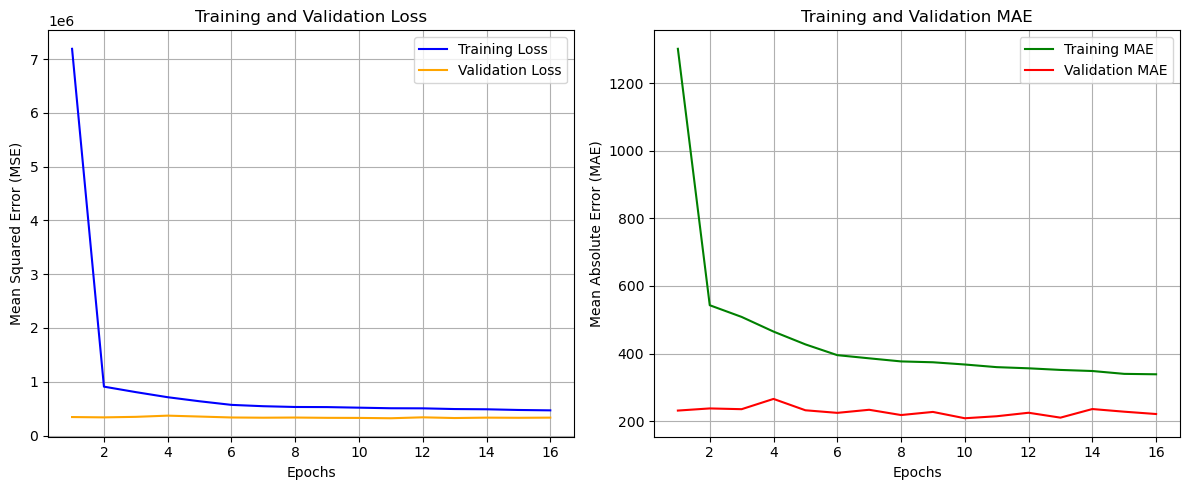

In [12]:
# Extract metrics from history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
mae = history_dict['mae']
val_mae = history_dict['val_mae']

epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, label='Training MAE', color='green')
plt.plot(epochs, val_mae, label='Validation MAE', color='red')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

### Calcular promedios de métricas
- **`np.mean()`**: Calcula el promedio de los valores almacenados en las listas de métricas.
  - **`mse_mean`**: Promedio del error cuadrático medio (MSE) en todos los pliegues.
  - **`mae_mean`**: Promedio del error absoluto medio (MAE) en todos los pliegues.
  - **`r2_mean`**: Promedio del coeficiente de determinación (R²) en todos los pliegues.

---

### Generar gráficos de métricas
- **`plt.figure()`**: Crea una figura para contener los gráficos con un tamaño de 15x5.

---

### Gráfico de MSE
- **Objetivo**: Visualizar el MSE en cada pliegue y su promedio.
  - **`plt.bar()`**: Dibuja un gráfico de barras para los valores de MSE en cada pliegue.
  - **`plt.axhline()`**: Dibuja una línea horizontal para el promedio de MSE.
  - **`plt.xlabel()`**: Etiqueta el eje X como "Fold".
  - **`plt.ylabel()`**: Etiqueta el eje Y como "MSE".
  - **`plt.title()`**: Título del gráfico: "MSE en cada fold y promedio".
  - **`plt.legend()`**: Añade una leyenda para las barras y el promedio.

---

### Gráfico de MAE
- **Objetivo**: Visualizar el MAE en cada pliegue y su promedio.
  - **`plt.bar()`**: Dibuja un gráfico de barras para los valores de MAE en cada pliegue.
  - **`plt.axhline()`**: Dibuja una línea horizontal para el promedio de MAE.
  - **`plt.xlabel()`**: Etiqueta el eje X como "Fold".
  - **`plt.ylabel()`**: Etiqueta el eje Y como "MAE".
  - **`plt.title()`**: Título del gráfico: "MAE en cada fold y promedio".
  - **`plt.legend()`**: Añade una leyenda para las barras y el promedio.

---

### Gráfico de R²
- **Objetivo**: Visualizar el R² en cada pliegue y su promedio.
  - **`plt.bar()`**: Dibuja un gráfico de barras para los valores de R² en cada pliegue.
  - **`plt.axhline()`**: Dibuja una línea horizontal para el

---

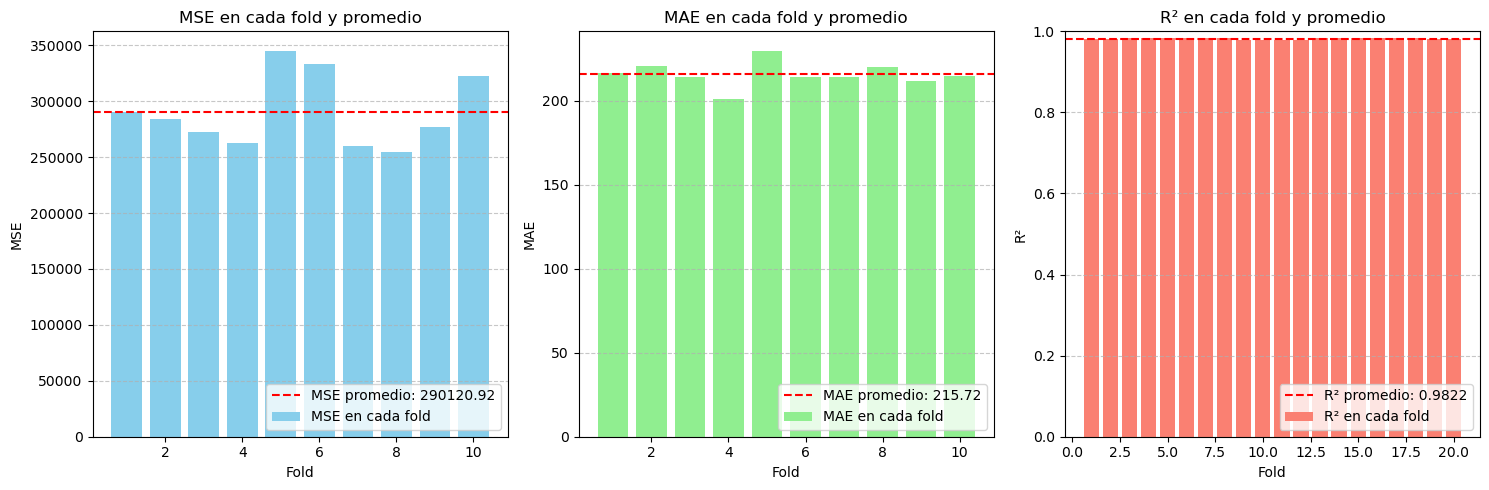

In [13]:
mse_mean = np.mean(mse_scores)
mae_mean = np.mean(mae_scores)
r2_mean = np.mean(r2_scores)


# Generate plots
plt.figure(figsize=(15, 5))

# Plot MSE
plt.subplot(1, 3, 1)
plt.bar(range(1, len(mse_scores) + 1), mse_scores, color='skyblue', label="MSE en cada fold")
plt.axhline(mse_mean, color='red', linestyle='--', label=f"MSE promedio: {mse_mean:.2f}")
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.title("MSE en cada fold y promedio")
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot MAE
plt.subplot(1, 3, 2)
plt.bar(range(1, len(mae_scores) + 1), mae_scores, color='lightgreen', label="MAE en cada fold")
plt.axhline(mae_mean, color='red', linestyle='--', label=f"MAE promedio: {mae_mean:.2f}")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.title("MAE en cada fold y promedio")
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot R²
plt.subplot(1, 3, 3)
plt.bar(range(1, len(r2_scores) + 1), r2_scores, color='salmon', label="R² en cada fold")
plt.axhline(r2_mean, color='red', linestyle='--', label=f"R² promedio: {r2_mean:.4f}")
plt.xlabel("Fold")
plt.ylabel("R²")
plt.ylim(0, 1)  # Limit R² values between 0 and 1
plt.title("R² en cada fold y promedio")
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Función: Comparación de valores reales y predichos
- **Objetivo**: Graficar los valores reales (`Y_test`) frente a los valores predichos (`Y_pred`) para analizar el rendimiento del modelo.
- **Parámetros**:
  - **`Y_test`**: Valores reales del conjunto de prueba.
  - **`Y_pred`**: Valores predichos por el modelo.
  - **`num_samples`**: Número de muestras a visualizar en la gráfica detallada (por defecto, 750).

---

### Gráfica general
- **Objetivo**: Mostrar todos los valores reales y predichos en una misma gráfica.
- **Detalles**:
  - **`plt.plot()`**: Dibuja las curvas de valores reales y predichos.
  - **`plt.title()`**: Título del gráfico: "Comparación de Valores Reales y Predichos (DC_POWER)".
  - **`plt.xlabel()` y `plt.ylabel()`**: Etiquetas para los ejes.
  - **`plt.legend()`**: Diferencia entre la curva de valores reales y la de predichos.
  - **`plt.grid()`**: Añade una cuadrícula al fondo para mejorar la visualización.

---

### Gráfica detallada (primeras `num_samples` muestras)
- **Objetivo**: Mostrar una sección ampliada de los valores reales y predichos para analizar en detalle.
- **Detalles**:
  - **`plt.plot()`**: Dibuja los valores reales y predichos para las primeras `num_samples` muestras, con marcadores distintos (`o` y `x`).
  - **`plt.title()`**: Título dinámico que incluye el número de muestras analizadas.
  - **`plt.xlabel()` y `plt.ylabel()`**: Etiquetas de los ejes para mayor claridad.
  - **`plt.legend()`**: Indica qué datos corresponden a los valores reales y a los predichos.

---

### Llamada a la función
- **Uso**: Se llama a la función `plot_real_vs_predicted()` con los valores reales (`Y_test`) y predichos (`Y_pred`) generados anteriormente.


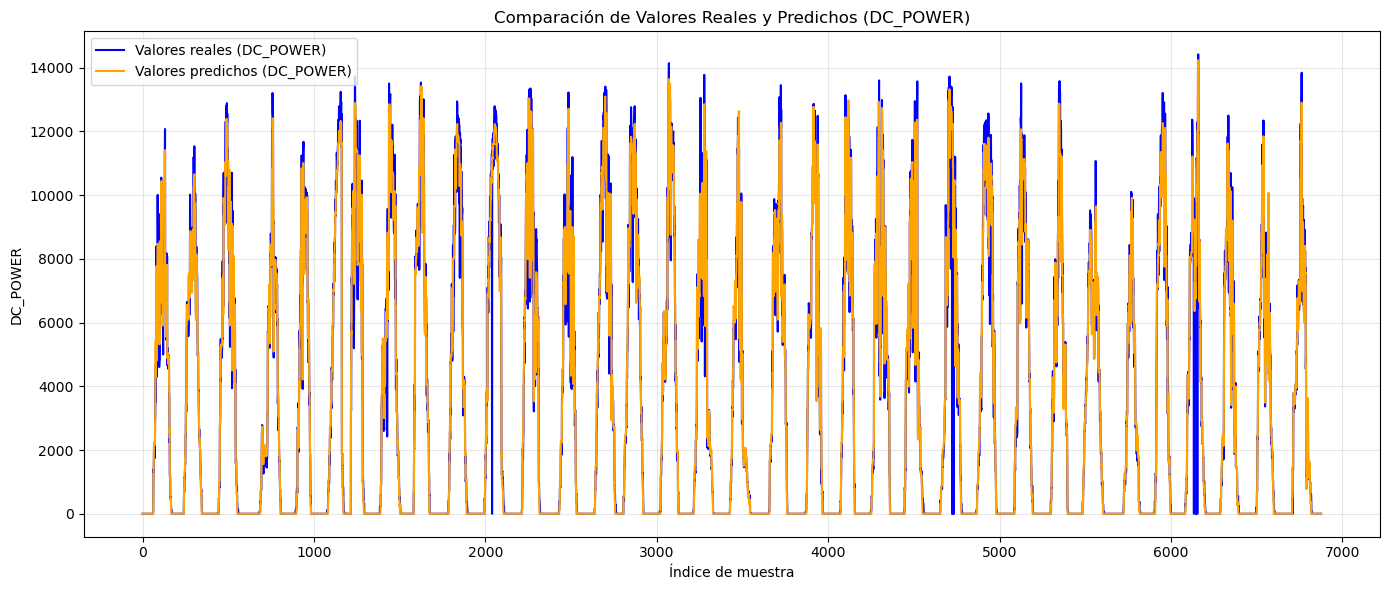

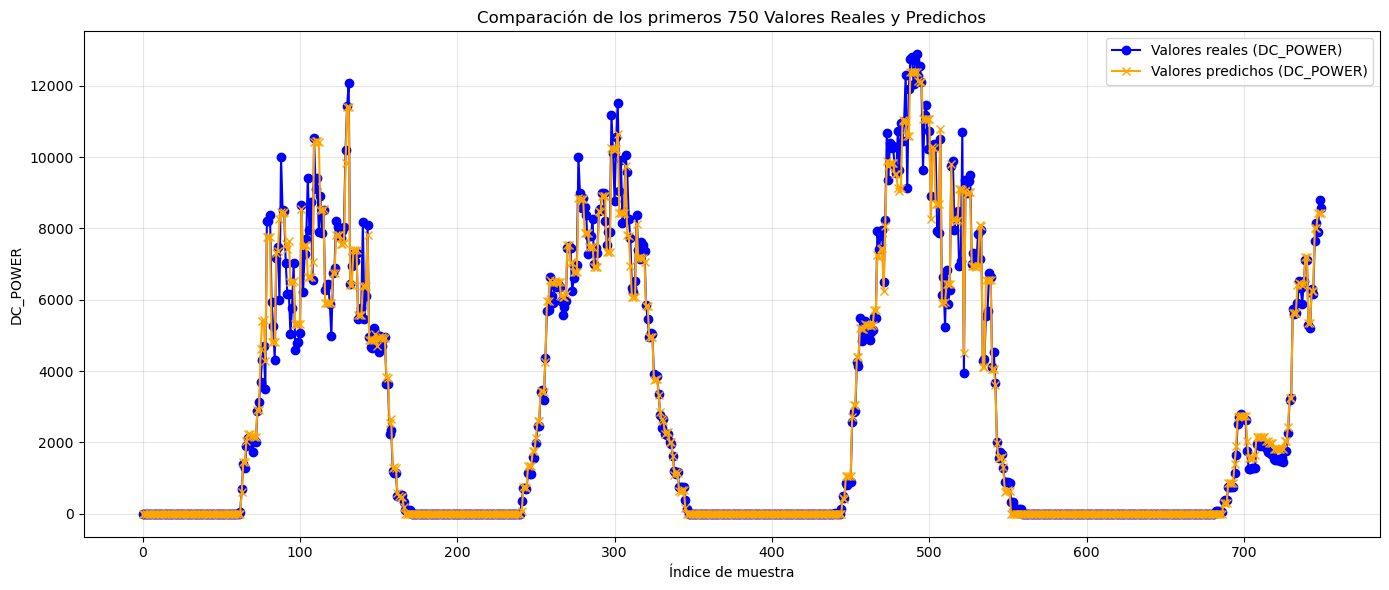

In [14]:
def plot_real_vs_predicted(Y_test, Y_pred, num_samples=750):
    # Crear una gráfica general
    plt.figure(figsize=(14, 6))
    plt.plot(Y_test, label='Valores reales (DC_POWER)', color='blue')
    plt.plot(Y_pred, label='Valores predichos (DC_POWER)', color='orange')
    plt.title('Comparación de Valores Reales y Predichos (DC_POWER)')
    plt.xlabel('Índice de muestra')
    plt.ylabel('DC_POWER')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Crear una gráfica con una sección ampliada
    plt.figure(figsize=(14, 6))
    plt.plot(Y_test[:num_samples], label='Valores reales (DC_POWER)', color='blue', marker='o')
    plt.plot(Y_pred[:num_samples], label='Valores predichos (DC_POWER)', color='orange', marker='x')
    plt.title(f'Comparación de los primeros {num_samples} Valores Reales y Predichos')
    plt.xlabel('Índice de muestra')
    plt.ylabel('DC_POWER')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Llamar a la función con los valores reales y predichos
plot_real_vs_predicted(Y_test, Y_pred)